In [33]:
!pip install pdpbox
!pip install tox tox-venv
!pip install shap
!pip install eli5
!pip install xgboost
!pip install category_encoders 
!pip install -U scikit-learn
!pip install category_encoders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
import seaborn as sns
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import warnings

from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder


In [34]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [35]:
operators = pd.read_csv('/content/gdrive/MyDrive/cpding/asdf/레식 데이터.csv', sep=',')

In [36]:
operators['k/d_ratio'] = pd.to_numeric(operators['nbkills']) / pd.to_numeric(operators['nbdeaths'])
operators['win_ratio'] = pd.to_numeric(operators['nbwins']) / pd.to_numeric(operators['nbpicks'])


In [58]:


operators_bronze = operators[operators["skillrank"] == "Bronze"].index 
operators_copper = operators[operators["skillrank"] == "Copper"].index
operators_Unranked = operators[operators["skillrank"] == "Unranked"].index

operators = operators.drop(operators_bronze)
operators = operators.drop(operators_copper)
operators = operators.drop(operators_Unranked)

##
operators_zero = operators[operators["win_ratio"] == 1.0].index 
operators_one = operators[operators["win_ratio"] == 0].index 

operators = operators.drop(operators_zero)
operators = operators.drop(operators_one)

##

operators = operators.replace([np.inf, -np.inf], np.nan).dropna()
# 일반인 플레이를 진행하지 않는 언랭크, 카퍼, 브론즈 랭크를 제외 


In [122]:
ATT_operators = operators[operators["role"] =="Attacker"]


In [60]:
DEF_operators = operators[operators["role"] =="Defender"]

In [61]:
ATT_operators = ATT_operators.sort_values(by='win_ratio' ,ascending=False)


In [112]:
ATT_operators_grap=ATT_operators[["operator","win_ratio","nbpicks"]]
ATT_operators_grap=ATT_operators_grap.groupby(['operator'], as_index=False).mean()
#ATT_operators_grap
ATT_operators_grap=ATT_operators_grap.drop([3,7,10,16,18])

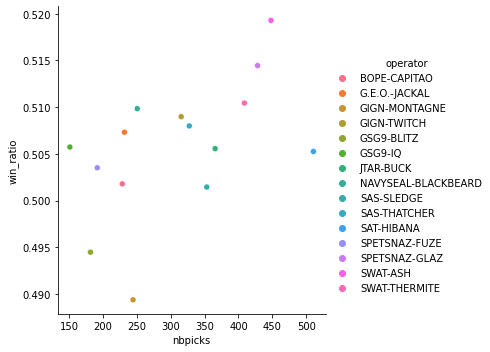

In [113]:
sns.relplot(x="nbpicks", y="win_ratio", hue="operator", data=ATT_operators_grap)

plt.show()

In [120]:
DEF_operators_grap=DEF_operators[["operator","win_ratio","nbpicks"]] 
DEF_operators_grap=DEF_operators_grap.groupby(['operator'], as_index=False).mean()
#DEF_operators_grap
DEF_operators_grap=DEF_operators_grap.drop([3,7,11,15,19])

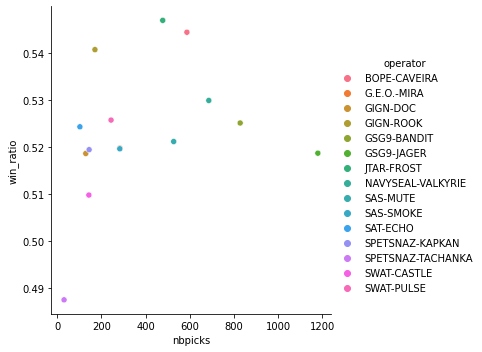

In [121]:
sns.relplot(x="nbpicks", y="win_ratio", hue="operator", data=DEF_operators_grap)

plt.show()

In [71]:
ATT_operators.drop(["skillrank", "role", "operator", "secondarygadget"], axis=1 , inplace=True)

In [72]:
encoder = OneHotEncoder(use_cat_names= True)

In [73]:
DEF_operators.isna().sum().sort_values()

skillrank          0
role               0
operator           0
primaryweapon      0
secondaryweapon    0
secondarygadget    0
nbwins             0
nbkills            0
nbdeaths           0
nbpicks            0
k/d_ratio          0
win_ratio          0
dtype: int64

0.07782543967342191

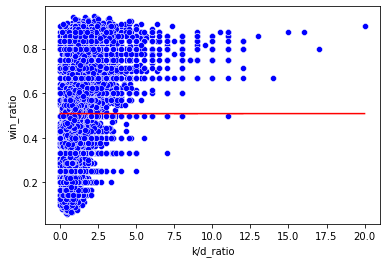

In [45]:
from sklearn.linear_model import LinearRegression
predict = operators['win_ratio'].mean()
errors = predict - operators['win_ratio']
mean_absolute_error = errors.abs().mean()

y = operators['win_ratio']
x = operators['k/d_ratio']

sns.lineplot(x=x, y=predict, color='red')
sns.scatterplot(x=x, y=y, color='blue')
mean_absolute_error

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


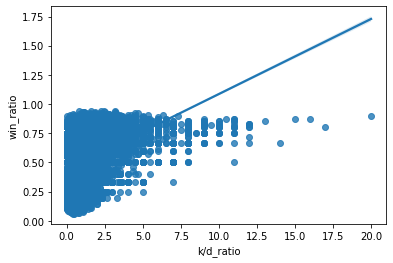

In [46]:
sns.regplot(x, y)

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
model = LinearRegression()
feature = ['k/d_ratio']
target = ['win_ratio']
X_train = operators[feature]
y_train = operators[target]
model.fit(X_train, y_train)



LinearRegression()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


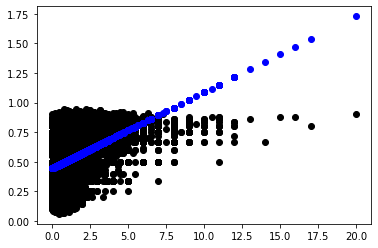

In [48]:
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score

X_test = [[x] for x in operators['k/d_ratio']]
y_pred = model.predict(X_test)
plt.scatter(X_train, y_train, color='black', linewidth=1)

plt.scatter(X_test, y_pred, color='blue', linewidth=1);

MAE = mean_absolute_error(X_test, y_pred)


In [49]:
print("정확도 MAE :")
MAE

정확도 MAE :


0.5548065508550163

In [50]:
#다중선형회귀 기본 골자
from sklearn.model_selection import train_test_split
x = ATT_operators[["nbwins" ,"nbkills","nbdeaths"]]
y = ATT_operators[['win_ratio']]
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size = 0.7, test_size = 0.3)
model = LinearRegression()
model = model.fit(x_train, y_train)

y_predict = model.predict(x_test)



In [51]:
Hot_ATT_operators=ATT_operators[["primaryweapon","secondaryweapon","k/d_ratio","win_ratio"] ]
Hot_DEF_operators=DEF_operators[["primaryweapon","secondaryweapon","k/d_ratio","win_ratio"] ]

In [52]:
Hot_ATT_operators = encoder.fit_transform(Hot_ATT_operators) # 원핫 인코딩 
Hot_DEF_operators = encoder.fit_transform(Hot_DEF_operators) # 원핫 인코딩 

In [53]:


cols = Hot_DEF_operators[['primaryweapon_SMG','primaryweapon_SG','primaryweapon_AR']]
target = Hot_DEF_operators["k/d_ratio"]


In [54]:
X_col = pd.DataFrame( data=cols)
y_target = pd.DataFrame( data=target)
linear = LinearRegression()
linear.fit(X_col, y_target)
print('R2: ', linear.score(X_col, y_target))
print('Intercept: ', linear.intercept_[0])


R2:  0.010836081026299516
Intercept:  2547698453798.9326


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


R2 0.002623978086583878


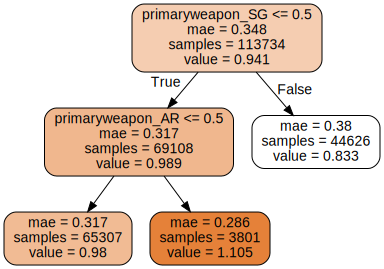

In [55]:
import graphviz
from ipywidgets import interact
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def show_tree(tree, colnames):
    dot = export_graphviz(tree, feature_names=colnames, filled=True, rounded=True)   
    return graphviz.Source(dot)

from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(criterion="mae")
tree.fit(X_col, y_target)
print('R2', tree.score(X_col, y_target))
show_tree(tree, colnames=X_col.columns)



R2:  0.026073903001090803
Intercept:  1.0029911965209035


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


R2 0.015332933452986364


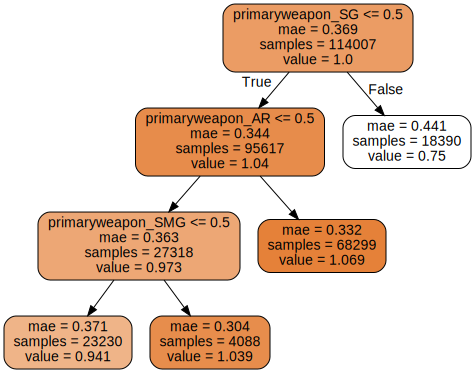

In [56]:


cols = Hot_ATT_operators[['primaryweapon_SMG','primaryweapon_SG','primaryweapon_AR']]
target = Hot_ATT_operators["k/d_ratio"]

X_col = pd.DataFrame( data=cols)
y_target = pd.DataFrame( data=target)
linear = LinearRegression()
linear.fit(X_col, y_target)
print('R2: ', linear.score(X_col, y_target))
print('Intercept: ', linear.intercept_[0])

tree = DecisionTreeRegressor(criterion="mae")
tree.fit(X_col, y_target)
print('R2', tree.score(X_col, y_target))
show_tree(tree, colnames=X_col.columns)
